In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
import statsmodels.api as sm
import csv

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
import statsmodels.api as sm
import networkx as nx
from plotly.figure_factory import create_dendrogram
from scipy.sparse.csgraph import minimum_spanning_tree

In [2]:
class log_returns_class():
    def __init__(self, currencyOfInterest, Rate, log_gap, file_name):
        df = pd.read_csv(file_name)
        dataOI = df[df['Currency']==currencyOfInterest]
        dates = pd.to_datetime(dataOI['Date'])
        spotRates = dataOI[Rate]
        self.log_returns = np.log(spotRates.shift(log_gap)/spotRates)
        self.dates_log = dates.shift(log_gap)
        self.log_gap = log_gap
        self.spotRates = spotRates
        self.currencyOfInterest = currencyOfInterest
        
    def plotting(self):
        plt.ylabel("Log return")
        plt.xlabel("date")
        string = "Log return with "+ str(self.log_gap)+ " day break"
        plt.title(string)
        plt.plot(self.dates_log,self.log_returns)
        
    def autocorl_plot(self):
        pd.plotting.lag_plot(self.spotRates, lag=1)
        plt.show()
        
    def autocorl(self):
        dataframe = pd.concat([self.spotRates.shift(0)])
        for i in range(int(len(self.log_returns-1)*0.8)):
            dataframe_new  = pd.concat([self.spotRates.shift(i+1)])
            dataframe = pd.concat([dataframe, dataframe_new], axis=1)
        result = dataframe.corr()
        #print(result)
        for i in range((int(len(self.log_returns-2)*0.8)-1)):
            plt.scatter(i,result.iloc[i,0])
        plt.show()
    
    def corl_length(self):
        dataframe = pd.concat([self.spotRates.shift(0)])
        for i in range(int(len(self.log_returns-1)*0.8)):
            dataframe_new  = pd.concat([self.spotRates.shift(i+1)])
            dataframe = pd.concat([dataframe, dataframe_new], axis=1)
        result = dataframe.corr()
        Tot = 0
        for i in range((int(len(self.log_returns-2)*0.8)-1)):
            Tot = Tot + result.iloc[i,0]
            plt.scatter(i,2/(np.sqrt(i)))
            plt.scatter(i,result.iloc[i,0])
            if result.iloc[i,0] < 2/(np.sqrt(i)):
                print(i)
        plt.show()
    
    def autocorl_length(self):
        acf,confidence_interval=sm.tsa.acf(self.spotRates,nlags=len(self.spotRates), alpha=0.05,fft=False)
        lower_bound = confidence_interval[1:, 0] - acf[1:]
        plt.plot(-lower_bound)
        for i in range(len(acf)):
            if (-lower_bound[i])>acf[i]:
                self.AUTO_length = i
                break


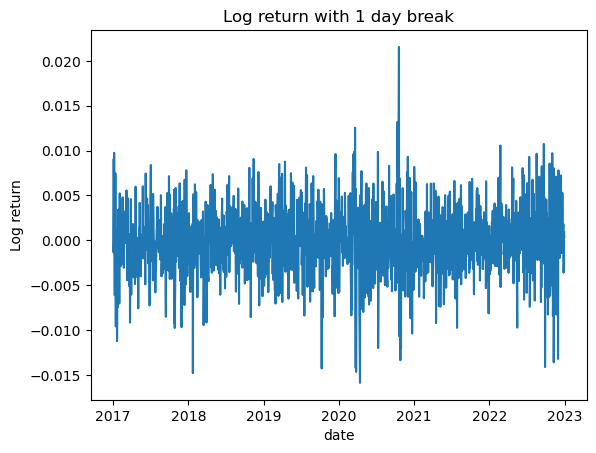

In [3]:
currencyOfInterest = 'GBP'
Rate = "Spot Rate"
file_name = "C:/Users/phbcat/OneDrive - Loughborough University/Group Project/Data/1128_1419_fx_tenor_curves_lboro_data_20231011.txt"
log_gap = 1

LOG_RET = log_returns_class(currencyOfInterest, Rate, log_gap, file_name)
LOG_RET.plotting()

In [4]:
def stats_SD(currencyOfInterest, Rate, log_gap, file_name,sliding_size, SD):
    LOG_RET = log_returns_class(currencyOfInterest, Rate, log_gap, file_name)
    log_returns = LOG_RET.log_returns
    dates_log = LOG_RET.dates_log
    Anom_log = []
    plt.plot(dates_log,log_returns)
    #number of standard deviations
    for i in range(len(log_returns)-sliding_size):
        window = []
        for j in range(sliding_size):
            window.append(log_returns.iloc[i+j])
        MEAN = np.mean(window)
        STANDARD = np.std(window)
        #plt.scatter(dates_log.iloc[i+sliding_size],MEAN+(SD*STANDARD),marker = 's',color='green')
        #plt.scatter(dates_log.iloc[i+sliding_size],MEAN-(SD*STANDARD),marker = 's',color='green')
        if log_returns.iloc[i+sliding_size] > MEAN+(SD*STANDARD):
            Anom_log.append(dates_log.iloc[i+sliding_size])
            #plt.scatter(dates_log.iloc[i+sliding_size],log_returns.iloc[i+sliding_size],marker = 'x',color='black')
        if log_returns.iloc[i+sliding_size] < MEAN-(SD*STANDARD):
            Anom_log.append(dates_log.iloc[i+sliding_size])
            #plt.scatter(dates_log.iloc[i+sliding_size],log_returns.iloc[i+sliding_size],marker = 'x',color='black')
        if log_returns.iloc[i+sliding_size] == 0:
            Anom_log.append(dates_log.iloc[i+sliding_size])
            #plt.scatter(dates_log.iloc[i+sliding_size],log_returns.iloc[i+sliding_size],marker = 'x',color='black')
    #plt.ylabel("Log return")
    #plt.xlabel("date")
    #plt.title(str(currencyOfInterest) +" "+ str(Rate) +" Standard deviation")
    #plt.show()
    return(Anom_log)

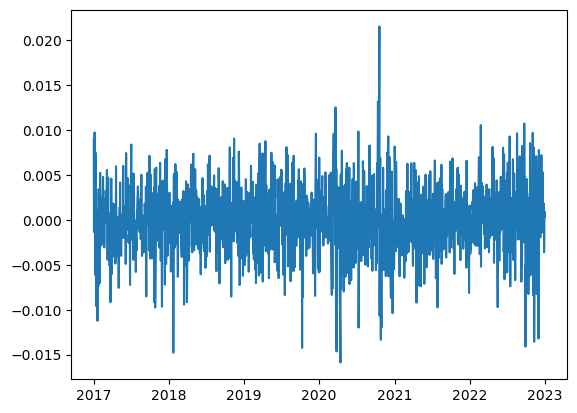

In [5]:
ANOM = stats_SD(currencyOfInterest, Rate, log_gap, file_name,92, 3)

In [39]:
def stats_IQR(currencyOfInterest, Rate, log_gap, file_name,sliding_size):
    LOG_RET = log_returns_class(currencyOfInterest, Rate, log_gap, file_name)
    log_returns = LOG_RET.log_returns
    dates_log = LOG_RET.dates_log
    Anom_log = []
    NUM_IQR = 3 #number of interquatile range
    plt.plot(dates_log,log_returns)
    for i in range(len(log_returns)-sliding_size):
        window = []
        for j in range(sliding_size):
            window.append(log_returns.iloc[i+j])
        q1, q3 = np.percentile(window,[25, 75])
        IQR = q3-q1
        
        plt.scatter(dates_log.iloc[i+sliding_size],q3+IQR*NUM_IQR,marker = 's',color='green')
        plt.scatter(dates_log.iloc[i+sliding_size],q1-IQR*NUM_IQR,marker = 's',color='green')
        if log_returns.iloc[i+sliding_size] > q3+IQR*NUM_IQR:
            Anom_log.append(dates_log.iloc[i+sliding_size])
            plt.scatter(dates_log.iloc[i+sliding_size],log_returns.iloc[i+sliding_size],marker = 'x',color='black')
        if log_returns.iloc[i+sliding_size] < q1-IQR*NUM_IQR:
            Anom_log.append(dates_log.iloc[i+sliding_size])
            plt.scatter(dates_log.iloc[i+sliding_size],log_returns.iloc[i+sliding_size],marker = 'x',color='black')
        if log_returns.iloc[i+sliding_size] == 0:
            Anom_log.append(dates_log.iloc[i+sliding_size])
            plt.scatter(dates_log.iloc[i+sliding_size],log_returns.iloc[i+sliding_size],marker = 'x',color='black')
    plt.ylabel("Log return")
    plt.xlabel("date")
    plt.title(str(currencyOfInterest) +" "+ str(Rate) +" IRQ")
    plt.show()
    print(100*len(Anom_log)/len(log_returns))
    return(Anom_log)

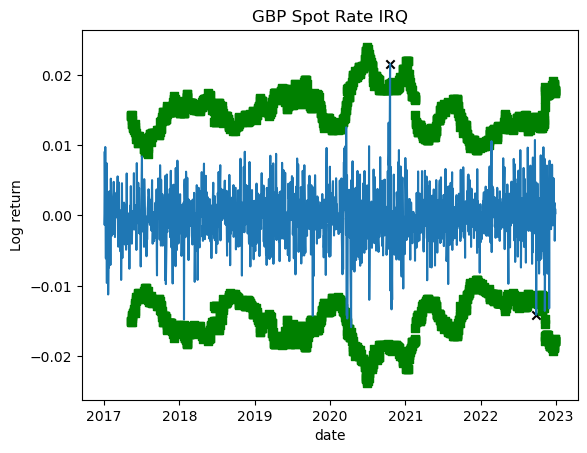

0.23995200959808038


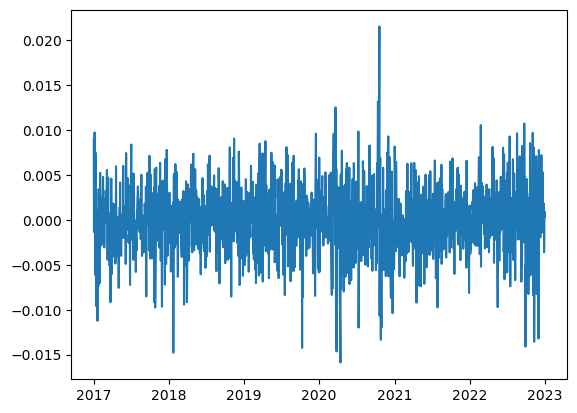

In [40]:
IQR_ANOM = stats_IQR(currencyOfInterest, Rate, log_gap, file_name,92)
SD_ANOM = stats_SD(currencyOfInterest, Rate, log_gap, file_name,92, 3)

In [8]:
num = 0
for i in range (len(IQR_ANOM)):
    for j in range (len(SD_ANOM)):
        if IQR_ANOM[i] == SD_ANOM[j]:
            num = num+1
print(round(100*num/len(IQR_ANOM),1), "% IQR") 
print(round((100*num/len(SD_ANOM)),1), "% SD")
print(len(SD_ANOM))
print(len(IQR_ANOM))
print(num)

28.3 % IQR
100.0 % SD
17
60
17


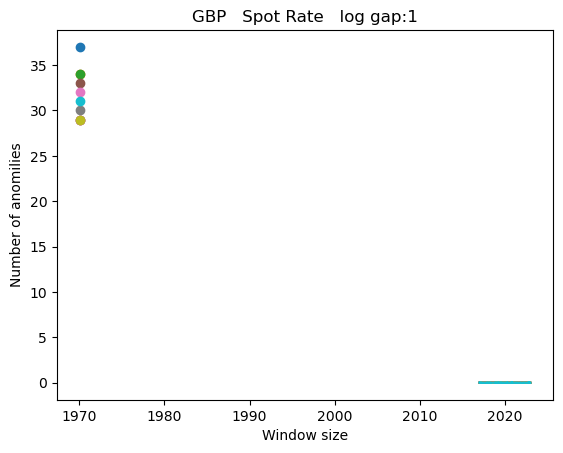

In [9]:
#LOG_RET = log_returns_class(currencyOfInterest, Rate, 1, file_name)
#log_returns = LOG_RET.log_returns
#length = len(log_returns)

for i in range(10):
    ANOM = stats_SD(currencyOfInterest, Rate, log_gap, file_name,i+15, 3)
    plt.scatter(i+15,len(ANOM))
    plt.ylabel("Number of anomilies")
    plt.xlabel("Window size")
    plt.title(str(currencyOfInterest) +"   "+ str(Rate)+"   log gap:" + str(log_gap))

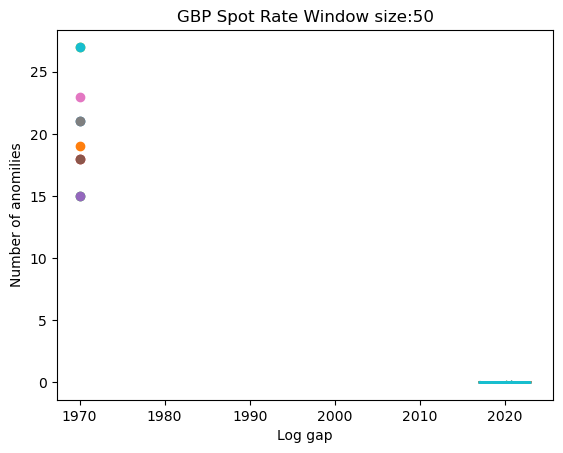

In [10]:
#LOG_RET = log_returns_class(currencyOfInterest, Rate, 1, file_name)
#log_returns = LOG_RET.log_returns
#length = len(log_returns)

for i in range(10):
    ANOM = stats_SD(currencyOfInterest, Rate, i+1, file_name,50, 3)
    plt.scatter(i+1,len(ANOM))
    plt.ylabel("Number of anomilies")
    plt.xlabel("Log gap")
    plt.title(str(currencyOfInterest) +" "+ str(Rate)+" Window size:" + str(50))

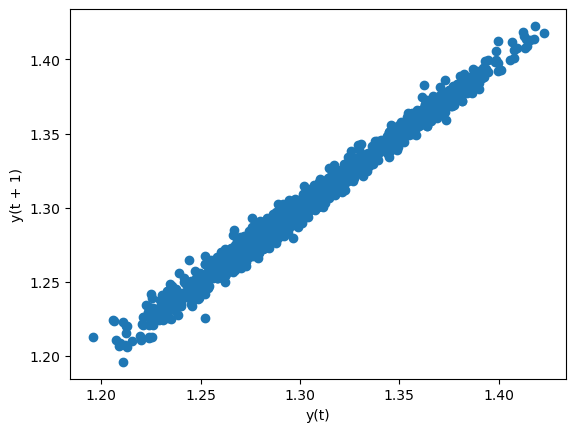

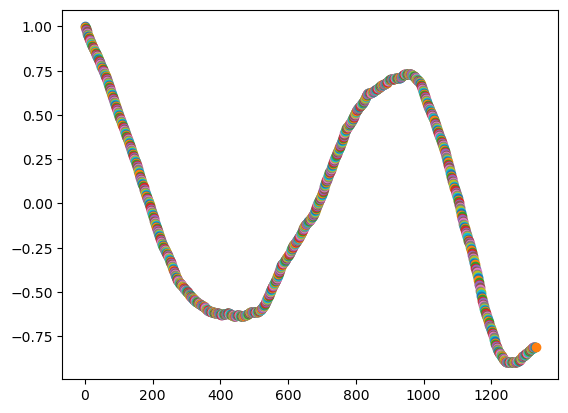

In [11]:
currencyOfInterest = 'GBP'
Rate = "Spot Rate"
file_name = "C:/Users/phbcat/OneDrive - Loughborough University/Group Project/Data/1128_1419_fx_tenor_curves_lboro_data_20231011.txt"
log_gap = 1

LOG_RET = log_returns_class(currencyOfInterest, Rate, log_gap, file_name)
LOG_RET.autocorl_plot()
LOG_RET.autocorl()
#LOG_RET.plotting()

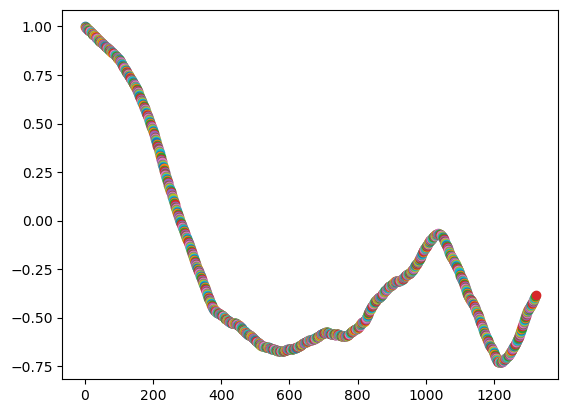

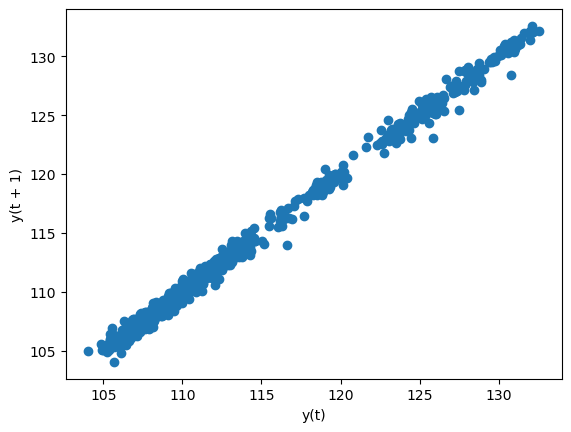

In [12]:
currencyOfInterest = 'JPY'
Rate = "Spot Rate"
file_name = "C:/Users/phbcat/OneDrive - Loughborough University/Group Project/Data/1128_1419_fx_tenor_curves_lboro_data_20231011.txt"
log_gap = 1

LOG_RET = log_returns_class(currencyOfInterest, Rate, log_gap, file_name)
#LOG_RET.plotting()
LOG_RET.autocorl()
LOG_RET.autocorl_plot()

<function matplotlib.pyplot.show(close=None, block=None)>

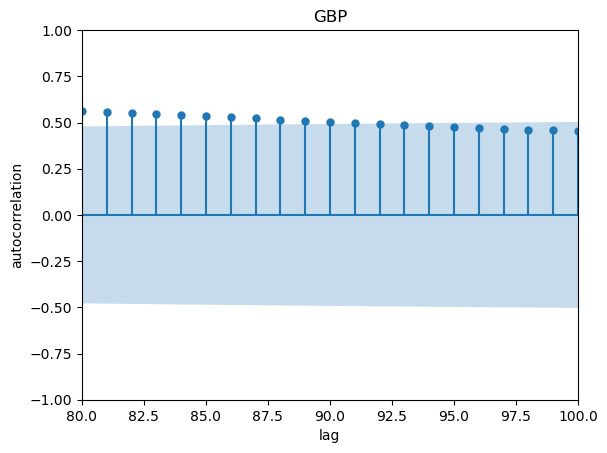

In [42]:
currencyOfInterest = 'GBP'
LOG_RET = log_returns_class(currencyOfInterest, Rate, log_gap, file_name)
plot_acf(LOG_RET.spotRates,lags = (len(LOG_RET.spotRates)-1)/1)
plt.xlabel("lag")
plt.ylabel("autocorrelation")
plt.title(currencyOfInterest)
plt.show
plt.xlim(80, 100)
plt.show

(100.0, 120.0)

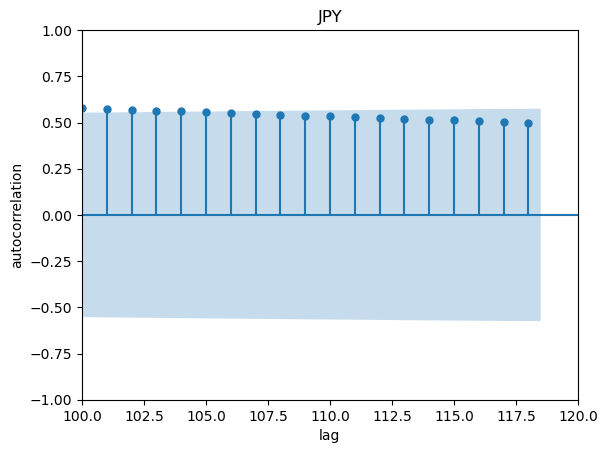

In [14]:
currencyOfInterest = 'JPY'
LOG_RET = log_returns_class(currencyOfInterest, Rate, log_gap, file_name)
plot_acf(LOG_RET.spotRates,lags = (len(LOG_RET.spotRates)-1)/14)
plt.xlabel("lag")
plt.ylabel("autocorrelation")
plt.title(currencyOfInterest)
plt.show
plt.xlim(100, 120)

<function matplotlib.pyplot.show(close=None, block=None)>

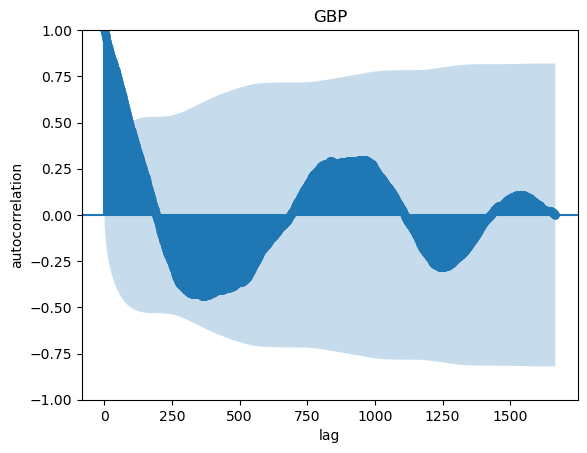

In [15]:
currencyOfInterest = 'GBP'
LOG_RET = log_returns_class(currencyOfInterest, Rate, log_gap, file_name)
plot_acf(LOG_RET.spotRates,lags = (len(LOG_RET.spotRates)-1)/1)
plt.xlabel("lag")
plt.ylabel("autocorrelation")
plt.title(currencyOfInterest)
plt.show
#plt.xlim(80,100)

<function matplotlib.pyplot.show(close=None, block=None)>

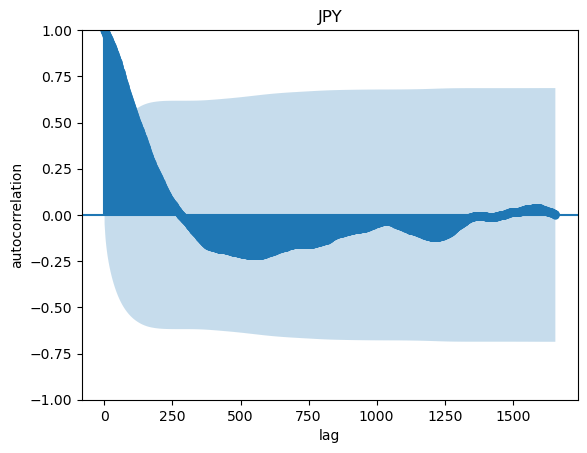

In [16]:
currencyOfInterest = 'JPY'
LOG_RET = log_returns_class(currencyOfInterest, Rate, log_gap, file_name)
plot_acf(LOG_RET.spotRates,lags = (len(LOG_RET.spotRates)-1)/1,alpha = 0.05)
plt.xlabel("lag")
plt.ylabel("autocorrelation")
plt.title(currencyOfInterest)
plt.show
#plt.xlim(65, 80)
#print(acf)
#print(confidence_interval)


In [17]:
#GBP JPY CAD EUR
Rates = ["Spot Rate", "1W Rate", "2W Rate", "3W Rate", "1M Rate", "2M Rate", "3M Rate", "4M Rate", "6M Rate", "9M Rate", "1Y Rate", "2Y Rate", "3Y Rate", "4Y Rate", "5Y Rate", "10Y Rate"]
currencyOfInterest = 'JPY'
correlation = np.zeros((len(Rates),len(Rates)))

LOG_RET = log_returns_class(currencyOfInterest, Rates[0], 1, file_name)
Data_frame = pd.concat([LOG_RET.spotRates])

for i in range(len(Rates)-1):
    LOG_RET = log_returns_class(currencyOfInterest, Rates[i+1], 1, file_name)
    Data_frame = pd.concat([Data_frame, LOG_RET.spotRates], axis = 1)
#print(Data_frame)
Corrilation = Data_frame.corr()
#print(Corrilation)

with open('/Users/phbcat/Downloads/Corrl.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    current_row = []
    current_row.append(currencyOfInterest)
    for i in range(len(Corrilation)):
        current_row.append(Rates[i])
    writer.writerow(current_row)
    for i in range (len(Corrilation)):
        current_row = []
        current_row.append(Rates[i])
        for j in range (len(Corrilation)): 
            current_row.append(Corrilation.iloc[j,i])
        writer.writerow(current_row)

In [18]:
Rates = ["Spot Rate", "1W Rate", "2W Rate", "3W Rate", "1M Rate", "2M Rate", "3M Rate", "4M Rate", "6M Rate", "9M Rate", "1Y Rate", "2Y Rate", "3Y Rate", "4Y Rate", "5Y Rate", "10Y Rate"]
currencyOfInterest = 'GBP'
correlation = np.zeros((len(Rates),len(Rates)))

LOG_RET = log_returns_class(currencyOfInterest, Rates[0], 1, file_name)
Data_frame = pd.concat([LOG_RET.log_returns])

for i in range(len(Rates)-1):
    LOG_RET = log_returns_class(currencyOfInterest, Rates[i+1], 1, file_name)
    Data_frame = pd.concat([Data_frame, LOG_RET.log_returns], axis = 1)
#print(Data_frame)
Corrilation = Data_frame.corr()
#print(Corrilation)

#with open('/Users/phbcat/Downloads/Corrl.csv', 'w', newline='') as file:
#    writer = csv.writer(file)
#    current_row = []
#    current_row.append(currencyOfInterest)
#    for i in range(len(Corrilation)):
#        current_row.append(Rates[i])
#    writer.writerow(current_row)
#    for i in range (len(Corrilation)):
#        current_row = []
#        current_row.append(Rates[i])
#        for j in range (len(Corrilation)): 
#            current_row.append(Corrilation.iloc[j,i])
#        writer.writerow(current_row)

In [19]:
#print(Corrilation)
Distance = np.sqrt(2*(1-Corrilation))
#print(Distance)
tree = minimum_spanning_tree(Distance)
Rates = ["Spot", "1W", "2W", "3W", "1M", "2M", "3M", "4M", "6M", "9M", "1Y", "2Y", "3Y", "4Y", "5Y", "10Y"]

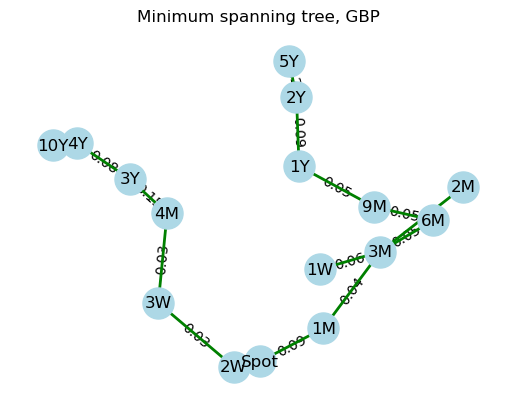

In [20]:
G = nx.Graph()
TREE_ARRAY = tree.toarray()
#TREE_ARRAY = Distance
for i in range(len(TREE_ARRAY)):
    for j in range(len(TREE_ARRAY)):
        if TREE_ARRAY[i][j]!=0:
            G.add_edges_from(
                [
                   (Rates[i], Rates[j], {"weight": round(TREE_ARRAY[i][j],2)} ) 
                ]
            )

T = nx.minimum_spanning_tree(G)
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_color="lightblue", node_size=500)
nx.draw_networkx_edges(G, pos, edge_color="grey")
nx.draw_networkx_labels(G, pos, font_size=12, font_family="sans-serif")
nx.draw_networkx_edge_labels(
    G, pos, edge_labels={(u, v): d["weight"] for u, v, d in G.edges(data=True)}
)
nx.draw_networkx_edges(T, pos, edge_color="green", width=2)
plt.axis("off")
plt.title("Minimum spanning tree, GBP")
plt.show()

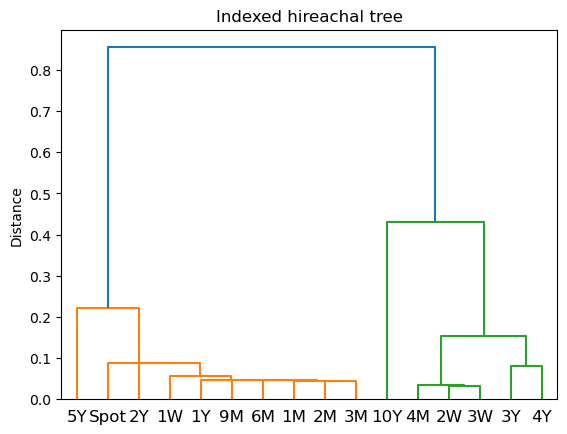

In [21]:
Distance = squareform(Distance)
linkage_matrix = linkage(Distance, "single")
dendrogram(linkage_matrix, labels = Rates)
plt.title("Indexed hireachal tree")
plt.ylabel("Distance")
plt.show()

In [22]:
print(tree)

  (0, 2)	0.8547647226914189
  (1, 6)	0.05656192986238776
  (2, 3)	0.03262602722586566
  (3, 7)	0.03495834608279861
  (4, 0)	0.08821726255745324
  (6, 4)	0.04369195140218326
  (6, 5)	0.04365529379798789
  (6, 8)	0.046615221647411345
  (7, 12)	0.15418118968715247
  (8, 9)	0.046818422971092455
  (9, 10)	0.047868771718532536
  (10, 11)	0.08694417294194959
  (12, 13)	0.08199030510320114
  (13, 15)	0.430753742064344
  (14, 11)	0.2211817885451685
